In [149]:
import pandas as pd
from haversine import haversine, Unit
import time
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [138]:
import findspark
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.context import SparkContext
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler

In [3]:
sc = SparkSession.builder.appName("go_bike").getOrCreate()

In [4]:
bike = pd.read_csv('2017-fordgobike-tripdata.csv')

In [5]:
bike.head(5)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,pyment
0,80110,12/31/2017 16:57:40,1/1/2018 15:12:50,74,Laguna St at Hayes St,37.776435,-122.426244,43,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,96,Customer,1987.0,Male,credit card
1,78800,12/31/2017 15:56:35,1/1/2018 13:49:56,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96,Dolores St at 15th St,37.766210,-122.426614,88,Customer,1965.0,Female,credit card
2,45768,12/31/2017 22:45:48,1/1/2018 11:28:37,245,Downtown Berkeley BART,37.870348,-122.267764,245,Downtown Berkeley BART,37.870348,-122.267764,1094,Customer,NaN,NaN,credit card
3,62172,12/31/2017 17:31:11,1/1/2018 10:47:24,60,8th St at Ringold St,37.774520,-122.409449,5,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,2831,Customer,NaN,NaN,credit card
4,43603,12/31/2017 14:23:14,1/1/2018 2:29:58,239,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247,Fulton St at Bancroft Way,37.867789,-122.265896,3167,Subscriber,1997.0,Female,app wallet


In [6]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519700 entries, 0 to 519699
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             519700 non-null  int64  
 1   start_time               519700 non-null  object 
 2   end_time                 519700 non-null  object 
 3   start_station_id         519700 non-null  int64  
 4   start_station_name       519700 non-null  object 
 5   start_station_latitude   519700 non-null  float64
 6   start_station_longitude  519700 non-null  float64
 7   end_station_id           519700 non-null  int64  
 8   end_station_name         519700 non-null  object 
 9   end_station_latitude     519700 non-null  float64
 10  end_station_longitude    519700 non-null  float64
 11  bike_id                  519700 non-null  int64  
 12  user_type                519700 non-null  object 
 13  member_birth_year        453159 non-null  float64
 14  memb

In [7]:
# Check if there are any records with out start location details
bike.start_station_latitude.value_counts().sum() ==  bike.start_station_longitude.value_counts().sum()

True

In [8]:
# Check if there are any records with out end location details
bike.end_station_latitude.value_counts().sum() == bike.end_station_longitude.value_counts().sum()

True

In [9]:
#Check if there are any duplicated records
bike.duplicated().sum()

0

In [10]:
def haversine_func(data):
    lon1 = data["start_station_longitude"]
    lat1 = data["start_station_latitude"]
    lon2 = data["end_station_longitude"]
    lat2 = data["end_station_latitude"]
    return haversine((lat1,lon1),(lat2,lon2))

In [11]:
bike['haversine_dist'] = bike.apply(lambda bike : haversine_func(bike), axis = 1)

In [12]:
bike.head(5)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,pyment,haversine_dist
0,80110,12/31/2017 16:57:40,1/1/2018 15:12:50,74,Laguna St at Hayes St,37.776435,-122.426244,43,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,96,Customer,1987.0,Male,credit card,0.942931
1,78800,12/31/2017 15:56:35,1/1/2018 13:49:56,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96,Dolores St at 15th St,37.766210,-122.426614,88,Customer,1965.0,Female,credit card,3.069730
2,45768,12/31/2017 22:45:48,1/1/2018 11:28:37,245,Downtown Berkeley BART,37.870348,-122.267764,245,Downtown Berkeley BART,37.870348,-122.267764,1094,Customer,NaN,NaN,credit card,0.000000
3,62172,12/31/2017 17:31:11,1/1/2018 10:47:24,60,8th St at Ringold St,37.774520,-122.409449,5,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,2831,Customer,NaN,NaN,credit card,1.046624
4,43603,12/31/2017 14:23:14,1/1/2018 2:29:58,239,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247,Fulton St at Bancroft Way,37.867789,-122.265896,3167,Subscriber,1997.0,Female,app wallet,0.636340


##  2 - Calculate the duration in seconds of each trip

In [14]:
bike['start_time']=pd.to_datetime(bike['start_time'])

In [15]:
bike['end_time']=pd.to_datetime(bike['end_time'])

In [16]:
 bike["trip_duration_in_sec"] = bike["end_time"]-bike["start_time"]

In [17]:
bike["trip_duration_in_sec"]

0        0 days 22:15:10
1        0 days 21:53:21
2        0 days 12:42:49
3        0 days 17:16:13
4        0 days 12:06:44
               ...      
519695   0 days 00:07:15
519696   0 days 00:07:11
519697   0 days 00:07:05
519698   0 days 00:06:06
519699   0 days 00:03:09
Name: trip_duration_in_sec, Length: 519700, dtype: timedelta64[ns]

In [18]:
bike["trip_duration_in_sec"] = bike["trip_duration_in_sec"].astype("timedelta64[s]")
bike["trip_duration_in_sec"]

0         80110.0
1         78801.0
2         45769.0
3         62173.0
4         43604.0
           ...   
519695      435.0
519696      431.0
519697      425.0
519698      366.0
519699      189.0
Name: trip_duration_in_sec, Length: 519700, dtype: float64

In [19]:
bike.head(5)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,pyment,haversine_dist,trip_duration_in_sec
0,80110,2017-12-31 16:57:40,2018-01-01 15:12:50,74,Laguna St at Hayes St,37.776435,-122.426244,43,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,96,Customer,1987.0,Male,credit card,0.942931,80110.0
1,78800,2017-12-31 15:56:35,2018-01-01 13:49:56,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96,Dolores St at 15th St,37.766210,-122.426614,88,Customer,1965.0,Female,credit card,3.069730,78801.0
2,45768,2017-12-31 22:45:48,2018-01-01 11:28:37,245,Downtown Berkeley BART,37.870348,-122.267764,245,Downtown Berkeley BART,37.870348,-122.267764,1094,Customer,NaN,NaN,credit card,0.000000,45769.0
3,62172,2017-12-31 17:31:11,2018-01-01 10:47:24,60,8th St at Ringold St,37.774520,-122.409449,5,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,2831,Customer,NaN,NaN,credit card,1.046624,62173.0
4,43603,2017-12-31 14:23:14,2018-01-01 02:29:58,239,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247,Fulton St at Bancroft Way,37.867789,-122.265896,3167,Subscriber,1997.0,Female,app wallet,0.636340,43604.0


### 3 - By assuming each minute cost 0.35 cent calculate the fee for each trip

In [20]:
bike["Cost of trip"] = (bike["trip_duration_in_sec"]/60)*0.35

In [21]:
bike.head(5)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,pyment,haversine_dist,trip_duration_in_sec,Cost of trip
0,80110,2017-12-31 16:57:40,2018-01-01 15:12:50,74,Laguna St at Hayes St,37.776435,-122.426244,43,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,96,Customer,1987.0,Male,credit card,0.942931,80110.0,467.308333
1,78800,2017-12-31 15:56:35,2018-01-01 13:49:56,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96,Dolores St at 15th St,37.766210,-122.426614,88,Customer,1965.0,Female,credit card,3.069730,78801.0,459.672500
2,45768,2017-12-31 22:45:48,2018-01-01 11:28:37,245,Downtown Berkeley BART,37.870348,-122.267764,245,Downtown Berkeley BART,37.870348,-122.267764,1094,Customer,NaN,NaN,credit card,0.000000,45769.0,266.985833
3,62172,2017-12-31 17:31:11,2018-01-01 10:47:24,60,8th St at Ringold St,37.774520,-122.409449,5,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,2831,Customer,NaN,NaN,credit card,1.046624,62173.0,362.675833
4,43603,2017-12-31 14:23:14,2018-01-01 02:29:58,239,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247,Fulton St at Bancroft Way,37.867789,-122.265896,3167,Subscriber,1997.0,Female,app wallet,0.636340,43604.0,254.356667


In [45]:
bike.to_csv("bike_reform", index=False)

## 4 - Calculating the total distance for each bike and listing top 10

In [23]:
bike_total_dist = bike.groupby('bike_id')[['haversine_dist']].sum().sort_values(by='haversine_dist', ascending=False)
bike_total_dist.head(10)

,haversine_dist
bike_id,
68,743.369482
2178,721.182243
256,671.916098
235,670.162003
2049,656.828102
441,656.642275
2226,647.823230
796,646.867730
190,640.294182


In [24]:
 bike['member_gender'].fillna("Not_filled", inplace = True)

In [25]:
bike["member_gender"].unique()

array(['Male', 'Female', 'Not_filled', 'Other'], dtype=object)

In [139]:
df_g = bike.groupby(["member_gender"]).count()

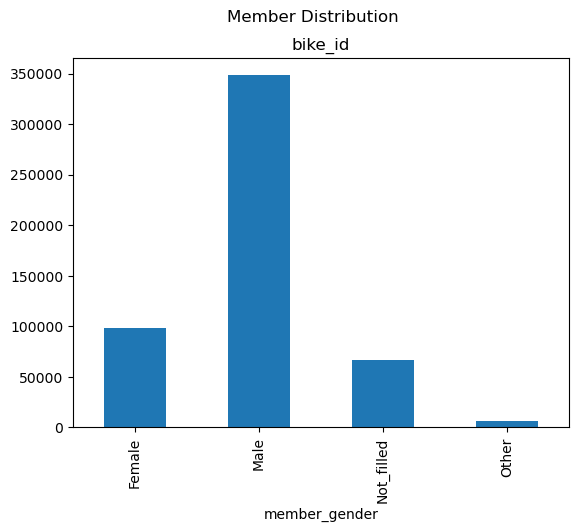

In [164]:
df_g["bike_id"].plot(kind = "bar", title = 'Member Distribution', subplots = True)
plt.show()

In [181]:
no_of_trips_per_station_sorted = bike.groupby(["start_station_id", "member_gender"]).count()["duration_sec"].unstack().head(5)

In [182]:
no_of_trips_per_station_sorted

member_gender,Female,Male,Not_filled,Other
start_station_id,,,,
3,1768.0,6070.0,2240.0,64.0
4,295.0,1491.0,735.0,7.0
5,1393.0,5240.0,1296.0,58.0
6,1938.0,7444.0,4163.0,119.0
7,769.0,1727.0,330.0,109.0


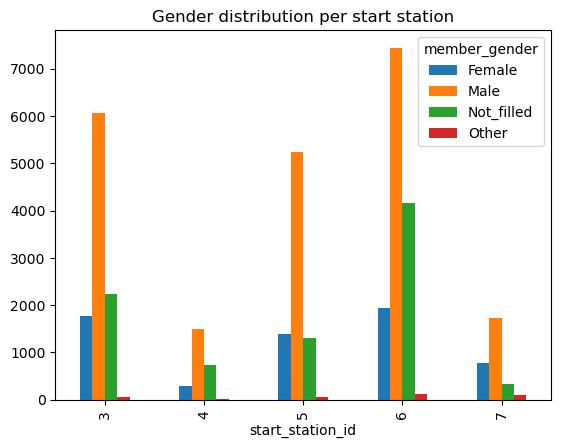

In [183]:
no_of_trips_per_station_sorted.plot(kind = "bar")
plt.title("Gender distribution per start station")
plt.show()

In [143]:
no_of_trips_per_station_sorted["sum"] = no_of_trips_per_station_sorted.sum(axis =1)

In [29]:
no_of_trips_per_station_sorted

member_gender,Female,Male,Not_filled,Other,sum
start_station_id,,,,,
3,1768.0,6070.0,2240.0,64.0,10142.0
4,295.0,1491.0,735.0,7.0,2528.0
5,1393.0,5240.0,1296.0,58.0,7987.0
6,1938.0,7444.0,4163.0,119.0,13664.0
7,769.0,1727.0,330.0,109.0,2935.0
...,...,...,...,...,...
327,36.0,221.0,21.0,NaN,278.0
337,9.0,26.0,NaN,2.0,37.0
338,9.0,44.0,8.0,NaN,61.0


In [30]:
no_of_trips_per_station_sorted['Female_Ratio'] = (no_of_trips_per_station_sorted['Female'] / no_of_trips_per_station_sorted["sum"]) * 100
no_of_trips_per_station_sorted['Male_Ratio'] = (no_of_trips_per_station_sorted['Male'] / no_of_trips_per_station_sorted["sum"]) * 100
no_of_trips_per_station_sorted['others_Ratio'] = (no_of_trips_per_station_sorted['Other'] / no_of_trips_per_station_sorted["sum"]) * 100
no_of_trips_per_station_sorted['Not_filled_Ratio'] = (no_of_trips_per_station_sorted['Not_filled'] / no_of_trips_per_station_sorted["sum"]) * 100

In [31]:
no_of_trips_per_station_sorted

member_gender,Female,Male,Not_filled,Other,sum,Female_Ratio,Male_Ratio,others_Ratio,Not_filled_Ratio
start_station_id,,,,,,,,,
3,1768.0,6070.0,2240.0,64.0,10142.0,17.432459,59.850128,0.631039,22.086373
4,295.0,1491.0,735.0,7.0,2528.0,11.669304,58.979430,0.276899,29.074367
5,1393.0,5240.0,1296.0,58.0,7987.0,17.440841,65.606611,0.726180,16.226368
6,1938.0,7444.0,4163.0,119.0,13664.0,14.183255,54.478923,0.870902,30.466920
7,769.0,1727.0,330.0,109.0,2935.0,26.201022,58.841567,3.713799,11.243612
...,...,...,...,...,...,...,...,...,...
327,36.0,221.0,21.0,NaN,278.0,12.949640,79.496403,NaN,7.553957
337,9.0,26.0,NaN,2.0,37.0,24.324324,70.270270,5.405405,NaN
338,9.0,44.0,8.0,NaN,61.0,14.754098,72.131148,NaN,13.114754


In [184]:
perc_bike = bike.value_counts('user_type', normalize = True)

In [185]:
perc_bike

user_type
Subscriber    0.787435
Customer      0.212565
dtype: float64

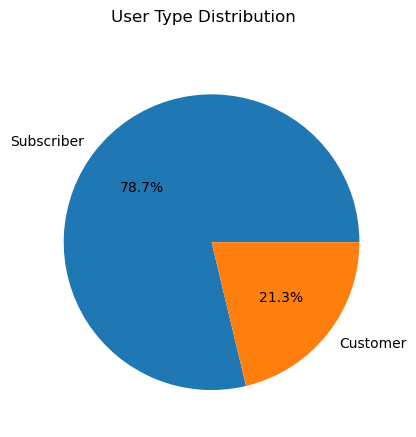

In [193]:
perc_bike.plot(kind = "pie", subplots = True, title = "User Type Distribution", autopct='%1.1f%%')
plt.show()

In [246]:
bike['start_time_year'] = bike["start_time"].dt.strftime('%Y').astype(int)
bike.head(5)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,pyment,haversine_dist,trip_duration_in_sec,Cost of trip,start_time_year
0,80110,2017-12-31 16:57:40,2018-01-01 15:12:50,74,Laguna St at Hayes St,37.776435,-122.426244,43,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,96,Customer,1987.0,Male,credit card,0.942931,80110.0,467.308333,2017
1,78800,2017-12-31 15:56:35,2018-01-01 13:49:56,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96,Dolores St at 15th St,37.766210,-122.426614,88,Customer,1965.0,Female,credit card,3.069730,78801.0,459.672500,2017
2,45768,2017-12-31 22:45:48,2018-01-01 11:28:37,245,Downtown Berkeley BART,37.870348,-122.267764,245,Downtown Berkeley BART,37.870348,-122.267764,1094,Customer,NaN,Not_filled,credit card,0.000000,45769.0,266.985833,2017
3,62172,2017-12-31 17:31:11,2018-01-01 10:47:24,60,8th St at Ringold St,37.774520,-122.409449,5,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,2831,Customer,NaN,Not_filled,credit card,1.046624,62173.0,362.675833,2017
4,43603,2017-12-31 14:23:14,2018-01-01 02:29:58,239,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247,Fulton St at Bancroft Way,37.867789,-122.265896,3167,Subscriber,1997.0,Female,app wallet,0.636340,43604.0,254.356667,2017


In [247]:
bike['start_time_year'].dtypes

dtype('int32')

In [248]:
#Calculate the age of all users and show the relation between the distance and the age

bike['member_age'] = bike['start_time_year'] - bike['member_birth_year']

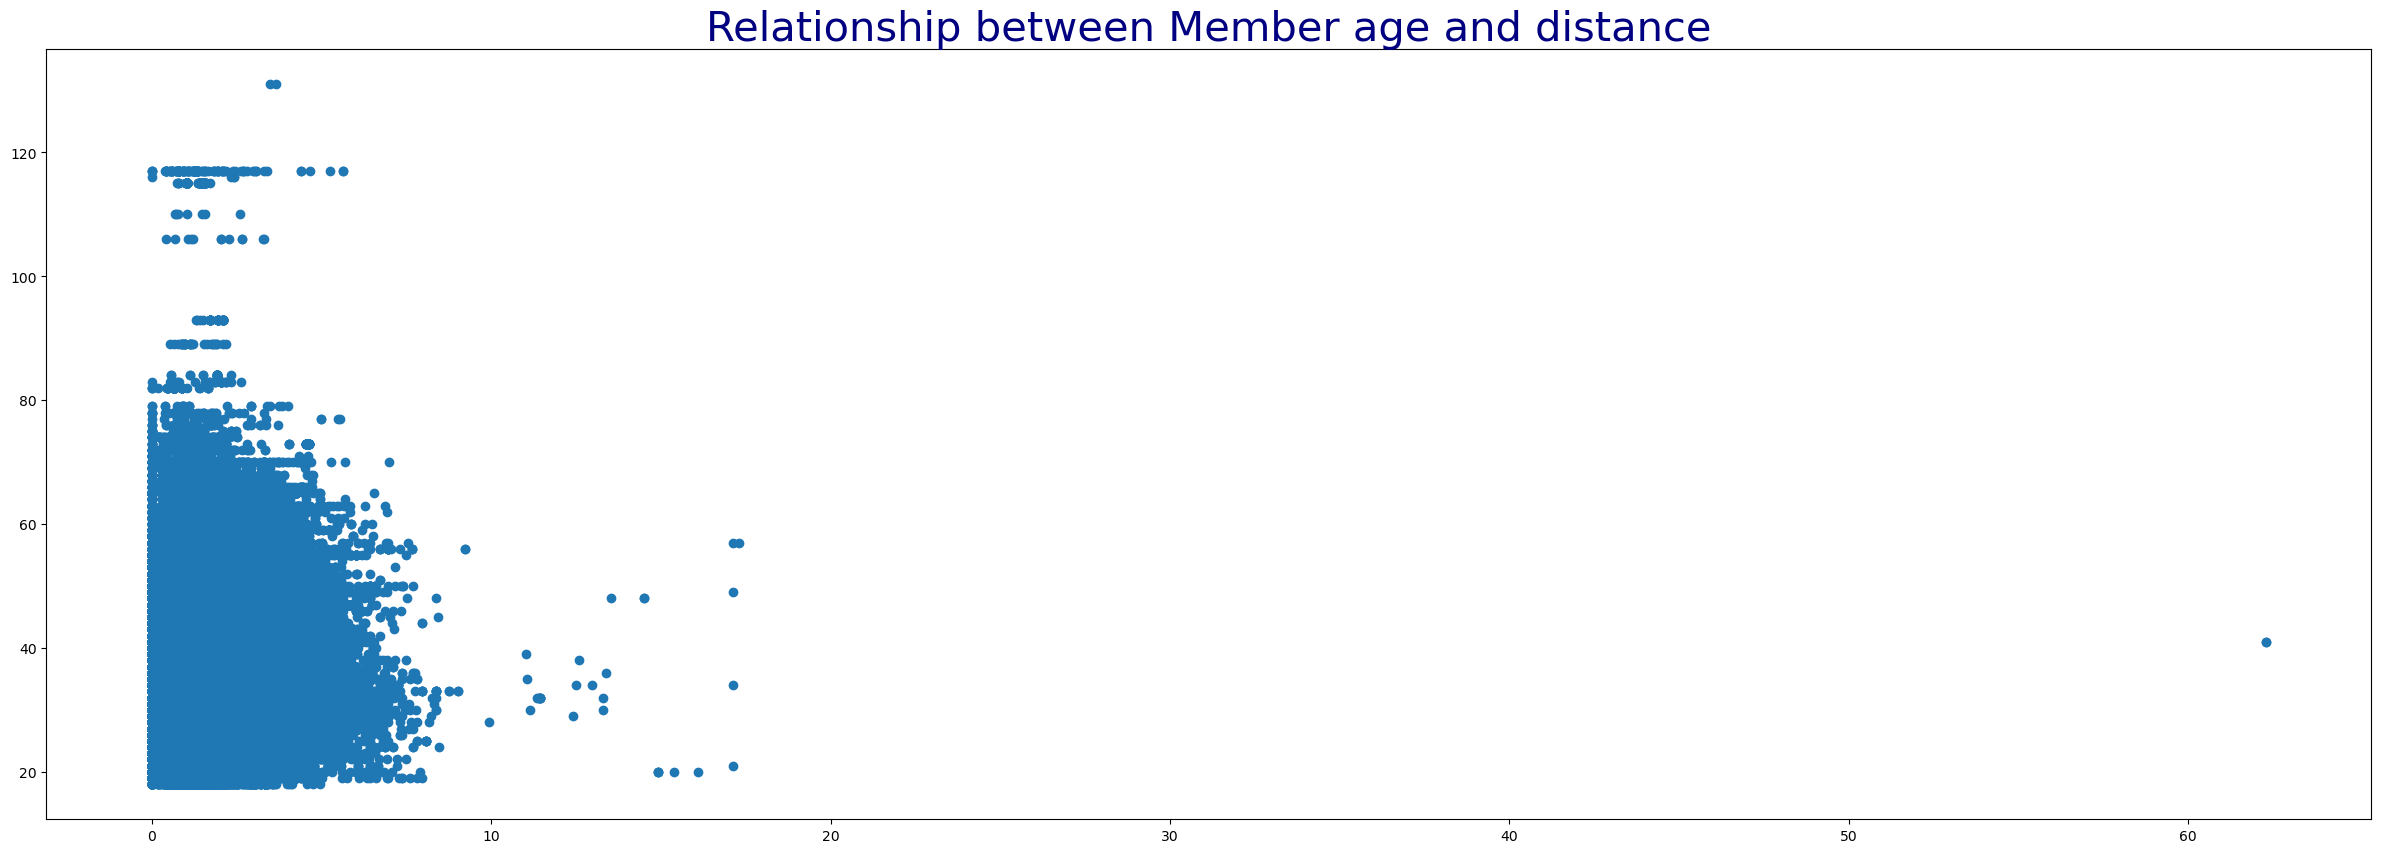

In [257]:
# plot the relationship between distance and age
fig = plt.figure(figsize=(30, 10))
plt.scatter(bike['haversine_dist'], bike['member_age'])
plt.title("Relationship between Member age and distance", fontsize = 30, color = "navy")
plt.show()

In [66]:
bike_1 = sc.read.csv("bike_reform", inferSchema=True, header = True)

In [67]:
bike_1.show(5)

+------------+-------------------+-------------------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+-------+----------+-----------------+-------------+-----------+------------------+--------------------+------------------+
|duration_sec|         start_time|           end_time|start_station_id|  start_station_name|start_station_latitude|start_station_longitude|end_station_id|    end_station_name|end_station_latitude|end_station_longitude|bike_id| user_type|member_birth_year|member_gender|     pyment|    haversine_dist|trip_duration_in_sec|      Cost of trip|
+------------+-------------------+-------------------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+-------+----------+-----------------+-------------+-----------+------------------+------------------

In [68]:
bike_1.columns

['duration_sec',
 'start_time',
 'end_time',
 'start_station_id',
 'start_station_name',
 'start_station_latitude',
 'start_station_longitude',
 'end_station_id',
 'end_station_name',
 'end_station_latitude',
 'end_station_longitude',
 'bike_id',
 'user_type',
 'member_birth_year',
 'member_gender',
 'pyment',
 'haversine_dist',
 'trip_duration_in_sec',
 'Cost of trip']

In [69]:
bike_1.dtypes

[('duration_sec', 'int'),
 ('start_time', 'timestamp'),
 ('end_time', 'timestamp'),
 ('start_station_id', 'int'),
 ('start_station_name', 'string'),
 ('start_station_latitude', 'double'),
 ('start_station_longitude', 'double'),
 ('end_station_id', 'int'),
 ('end_station_name', 'string'),
 ('end_station_latitude', 'double'),
 ('end_station_longitude', 'double'),
 ('bike_id', 'int'),
 ('user_type', 'string'),
 ('member_birth_year', 'double'),
 ('member_gender', 'string'),
 ('pyment', 'string'),
 ('haversine_dist', 'double'),
 ('trip_duration_in_sec', 'double'),
 ('Cost of trip', 'double')]

In [76]:
bike_1.groupby("user_type").sum("Cost of trip").show()

+----------+------------------+
| user_type| sum(Cost of trip)|
+----------+------------------+
|Subscriber|1684845.4000000018|
|  Customer|1648191.0666666655|
+----------+------------------+



In [201]:
Payment_distribution = bike_1.groupby("pyment").count()

In [234]:
PD = Payment_distribution.toPandas()

In [235]:
PD

,pyment,count
0,app wallet,260061
1,credit card,259639


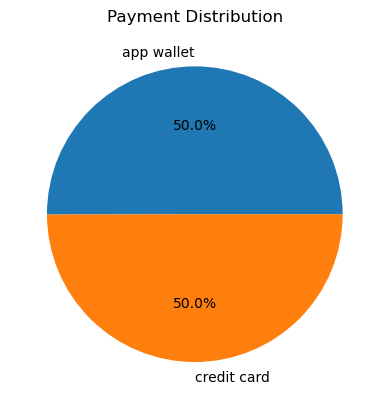

In [261]:
plt.pie(PD['count'], labels = PD["pyment"], autopct='%1.1f%%')
plt.title("Payment Distribution")
plt.show()

In [228]:
pay_analysis = bike_1.groupby("pyment").sum("Cost of trip")

In [195]:
pay_analysis.show()

+-----------+------------------+
|     pyment| sum(Cost of trip)|
+-----------+------------------+
| app wallet|1658717.3691666643|
|credit card|      1674319.0975|
+-----------+------------------+



In [125]:
Pay_analysis = pay_analysis.toPandas()

In [126]:
Pay_analysis

,pyment,sum(Cost of trip)
0,app wallet,1.658717e+06
1,credit card,1.674319e+06


In [129]:
Pay_analysis["ratio"] = (Pay_analysis["sum(Cost of trip)"]/Pay_analysis["sum(Cost of trip)"].sum())*100

In [130]:
Pay_analysis

,pyment,sum(Cost of trip),ratio
0,app wallet,1.658717e+06,49.765953
1,credit card,1.674319e+06,50.234047


In [135]:
bike_1.groupby("start_station_id").sum("Cost of trip").sort("sum(Cost of trip)").show()

+----------------+------------------+
|start_station_id| sum(Cost of trip)|
+----------------+------------------+
|             268|            2.8175|
|             339| 5.675833333333332|
|             292|20.025833333333335|
|             294| 40.53583333333332|
|             340| 52.63999999999999|
|             237| 70.79333333333331|
|             267|            73.395|
|             293| 76.46333333333331|
|             299|105.35583333333332|
|             337|             171.5|
|             301|199.91416666666666|
|             338|234.59333333333328|
|             216|234.65166666666664|
|             131| 245.0116666666667|
|             265| 277.9466666666667|
|             288| 285.8333333333333|
|             206|323.13166666666666|
|             258|330.66833333333324|
|             263|343.13416666666666|
|             254|373.16999999999996|
+----------------+------------------+
only showing top 20 rows

